In [25]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.1 MB/s eta 0:00:00


In [54]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer
import matplotlib.pyplot as plt

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [35]:
# Define params
symbols = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'SBIN.NS', 'HDFCBANK.NS', 'HDFC.NS', 'TITAN.NS', 'HEROMOTOCO.NS', 'TATAMOTORS.NS', 'BPCL.NS']
start_date = datetime(2018, 8, 1, tzinfo=pytz.utc)
end_date = datetime(2022, 8, 1, tzinfo=pytz.utc)
num_tests = 2000

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [36]:
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)

print(yfdata.symbols)

['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'SBIN.NS', 'HDFCBANK.NS', 'HDFC.NS', 'TITAN.NS', 'HEROMOTOCO.NS', 'TATAMOTORS.NS', 'BPCL.NS']


In [37]:
ohlcv = yfdata.concat()

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [39]:
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.8 MB/s eta 0:00:00


<Axes: xlabel='Date'>

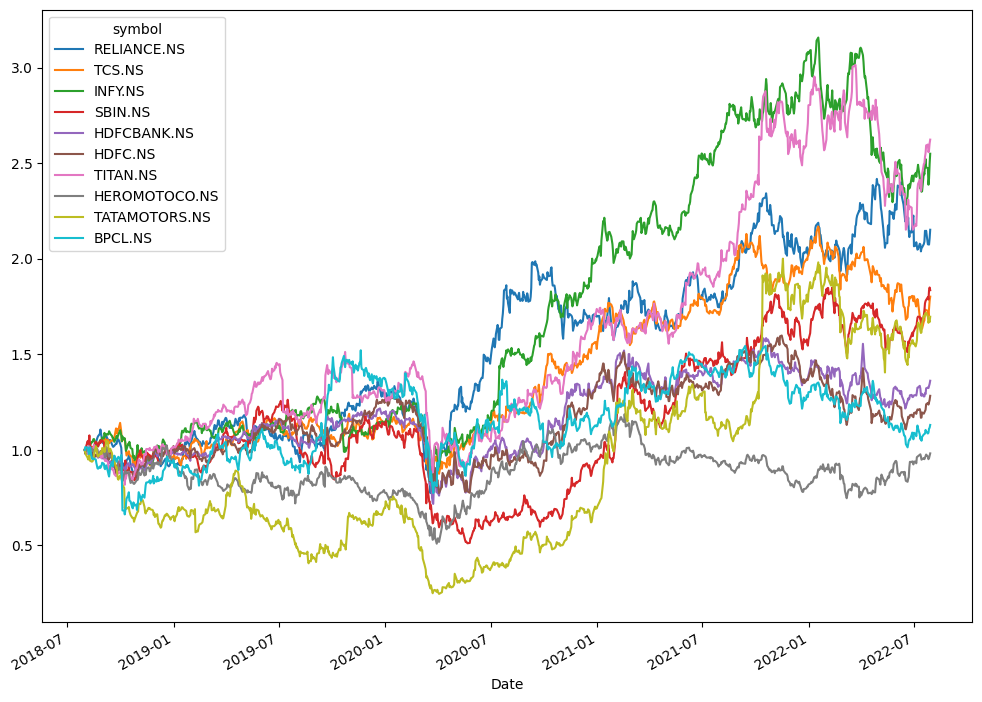

In [45]:
price = ohlcv['Close']
# Plot normalized price series
(price / price.iloc[0]).plot(figsize = (12,9))

In [46]:
returns = price.pct_change()

In [53]:
returns['BPCL.NS'].mean()

0.0004431623678428954

In [56]:
di = dict()

for sym in symbols:
    di[sym] = returns[sym].mean()

In [58]:
di

{'RELIANCE.NS': 0.0010034544327910862,
 'TCS.NS': 0.0007404427814687801,
 'INFY.NS': 0.0011313745357495132,
 'SBIN.NS': 0.0008944742095229233,
 'HDFCBANK.NS': 0.0004765075766986141,
 'HDFC.NS': 0.0004816288220460479,
 'TITAN.NS': 0.0011965707657088471,
 'HEROMOTOCO.NS': 0.0002052180080266721,
 'TATAMOTORS.NS': 0.0010895133458364212,
 'BPCL.NS': 0.0004431623678428954}

In [59]:
print(returns.std())

symbol
RELIANCE.NS      0.021282
TCS.NS           0.016895
INFY.NS          0.018982
SBIN.NS          0.023573
HDFCBANK.NS      0.018068
HDFC.NS          0.021366
TITAN.NS         0.020826
HEROMOTOCO.NS    0.021218
TATAMOTORS.NS    0.033452
BPCL.NS          0.025135
dtype: float64


In [60]:
print(returns.std())

symbol
RELIANCE.NS      0.021282
TCS.NS           0.016895
INFY.NS          0.018982
SBIN.NS          0.023573
HDFCBANK.NS      0.018068
HDFC.NS          0.021366
TITAN.NS         0.020826
HEROMOTOCO.NS    0.021218
TATAMOTORS.NS    0.033452
BPCL.NS          0.025135
dtype: float64


In [61]:
print(returns.corr())

symbol         RELIANCE.NS    TCS.NS   INFY.NS   SBIN.NS  HDFCBANK.NS  \
symbol                                                                  
RELIANCE.NS       1.000000  0.360112  0.316872  0.387557     0.424475   
TCS.NS            0.360112  1.000000  0.625285  0.241089     0.286869   
INFY.NS           0.316872  0.625285  1.000000  0.255919     0.321211   
SBIN.NS           0.387557  0.241089  0.255919  1.000000     0.535185   
HDFCBANK.NS       0.424475  0.286869  0.321211  0.535185     1.000000   
HDFC.NS           0.377498  0.319931  0.335726  0.561262     0.744165   
TITAN.NS          0.358144  0.283761  0.270281  0.388839     0.448650   
HEROMOTOCO.NS     0.354492  0.273772  0.257348  0.358280     0.436155   
TATAMOTORS.NS     0.368023  0.291298  0.271885  0.492581     0.368895   
BPCL.NS           0.387506  0.224055  0.202328  0.439663     0.360308   

symbol          HDFC.NS  TITAN.NS  HEROMOTOCO.NS  TATAMOTORS.NS   BPCL.NS  
symbol                                         

##One-time allocation

In [62]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [63]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.07200801115525138,    0,   'RELIANCE.NS'),
            ( 0.18278161119856334,    0,        'TCS.NS'),
            ( 0.14073105997227742,    0,       'INFY.NS'),
            ( 0.11509636655456425,    0,       'SBIN.NS'),
            (0.029995697219246602,    0,   'HDFCBANK.NS'),
            (0.029991059956664158,    0,       'HDFC.NS'),
            ( 0.01116698901526622,    0,      'TITAN.NS'),
            ( 0.16652854641932946,    0, 'HEROMOTOCO.NS'),
            ( 0.11556865150895665,    0, 'TATAMOTORS.NS'),
            ( 0.13613200699988054,    0,       'BPCL.NS'),
            ...
            ( 0.12329327667570818, 1999,   'RELIANCE.NS'),
            ( 0.16293601679565473, 1999,        'TCS.NS'),
            (   0.019208321944439, 1999,       'INFY.NS'),
            (  0.1057161266900053, 1999,       'SBIN.NS'),
            ( 0.19334527449896174, 1999,   'HDFCBANK.NS'),
            (  0.1881953711245603, 1999,       'HDFC.NS'),
            ( 0.01004536147411785, 1999,

In [64]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(986, 20000)


In [76]:
# Run simulation
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

19960


In [69]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show()

In [70]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

179


In [71]:
# Print best weights
print(weights[best_symbol_group])

[0.04878325 0.23955953 0.16639818 0.22097584 0.01353768 0.02754517
 0.2327017  0.023417   0.02314815 0.00393351]


Monthly Analysis of ALlocation

In [79]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

49


<ipython-input-79-cfbfc6a9a25c>:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [80]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(986, 20000)


In [81]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

979907


In [82]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

179


In [83]:
print(weights[rb_best_symbol_group])

[0.04878325 0.23955953 0.16639818 0.22097584 0.01353768 0.02754517
 0.2327017  0.023417   0.02314815 0.00393351]


In [84]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                           2018-07-31 18:30:00+00:00
End                             2022-07-28 18:30:00+00:00
Period                                  986 days 00:00:00
Start Value                                         100.0
End Value                                      225.648793
Total Return [%]                               125.648793
Benchmark Return [%]                            74.115425
Max Gross Exposure [%]                              100.0
Total Fees Paid                                  1.165293
Max Drawdown [%]                                35.810668
Max Drawdown Duration                   154 days 00:00:00
Total Trades                                          245
Total Closed Trades                                   235
Total Open Trades                                      10
Open Trade PnL                                  78.293174
Win Rate [%]                                    74.893617
Best Trade [%]                                 152.151362
Worst Trade [%

In [85]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show()

In [86]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group


In [87]:
# isnt it Nice?